In [1]:
# !pip install snowflake --user
# !pip install snowflake-connector-python --user
# # !pip install matplotlib
# # !pip install seaborn
# !pip install xgboost
#!pip install pycrypto

# Data

In [2]:
import os
import sys
import logging
import boto3
import itertools as it
import io
from utils import *
import snowflake.connector

In [3]:
from matplotlib.pyplot import figure

In [4]:
import matplotlib.pyplot as plt

In [5]:
from sklearn.model_selection import GroupKFold

In [6]:
import datetime

In [7]:
from datetime import timedelta

In [8]:
import scipy.stats as st

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


In [10]:
import re

In [11]:
from Crypto.Cipher import AES
import codecs
import json
import logging
import boto3
from botocore.exceptions import ClientError

logger = logging.getLogger(__name__)
decode_hex = codecs.getdecoder("hex_codec")

In [12]:
class SecretDecoder:
    def __init__(self, secret_name, region):
        self.secretsmanager_client = boto3.client(service_name='secretsmanager',
                region_name=region)
        secret = self.get_secret(secret_name)
        key_hex = json.loads(secret[u'SecretString'])[u'key']
        iv_hex = json.loads(secret[u'SecretString'])[u'iv']

        self.key = self.hex_to_bin(key_hex)
        self.iv = self.hex_to_bin(iv_hex)

    def get_secret(self, name):
        try:
            kwargs = {'SecretId': name}
            response = self.secretsmanager_client.get_secret_value(**kwargs)
        except ClientError:
            logger.exception("Couldn't get value for secret %s.", name)
            raise
        else:
            return response
    def get_aes(self):
        return AES.new(self.key, AES.MODE_CBC, self.iv)

    def hex_to_bin(self, value):
        return decode_hex(value)[0]

    def decrypt(self, value):
        value = self.hex_to_bin(value)
        aes = self.get_aes()
        decrypted_value = aes.decrypt(value)
        decoded_value = decrypted_value.decode("utf-8").strip('\b')
        return decoded_value

# if __name__ == '__main__':
sd = SecretDecoder('hbomax-dataeng-ckg-snowsheets-aeskey-dev', 'us-east-1')
print(sd.decrypt('cc2a6b2cca25167ba10200917b709e3e'))

$750,000


In [13]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

In [14]:
class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

In [15]:
def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

In [16]:
logger = logging.getLogger()
logger.info(f'Loading inputs')
data_list =[]

s3 = boto3.resource('s3')


In [17]:
bucket = s3.Bucket('hbo-ingest-datascience-content-beta')
for obj in bucket.objects.filter(Prefix='input_percent_view'):
    key = obj.key
    logger.info('Loading csv file {}'.format(key))
    body = obj.get()['Body']
    var_name = key.split('.')[0].split('/')[1]
    print('Reading {0} features'.format(var_name))
    exec("{0}=pd.read_csv(body, na_values = [r'\\\\N'])".format(var_name))
    exec("{0}.columns = {0}.columns.str.lower()".format(var_name))
    
    # exclude the full null columns
    exec("{0} = {0}.loc[:,{0}.isnull().sum()!={0}.shape[0]]".format(var_name))

    # exclude the old Mortal Kombat movie because the trailer percent view 
    # matching matches the trailer of the new movie to the old movie
    # exclude Tom & Jerry due to unresolvable data issue
    exec("{0} = {0}.loc[{0}['match_id_platform'].\
        isin(['1-GYGQBcwsaCIW2XgEAAAAL', '0-GYGQBcwsaCIW2XgEAAAAL', '1-GYEb9QwLgFF9_ZwEAAAA7', '0-GYEb9QwLgFF9_ZwEAAAA7'])==False,:]\
        .reset_index(drop = True)".format(var_name))
    
    # append the feature df
    exec("data_list.append({0})".format(var_name))

Reading funnel_metric_feature features
Reading media_cost_postlaunch_feature features
Reading media_cost_prelaunch_feature features
Reading metadata_feature features
Reading prelaunch_trailer_feature features
Reading prelaunch_trailer_feature_before28 features
Reading sub_total_feature features
Reading trailer_feature features
Reading vtp_feature features
Reading wiki_view_feature_before28 features
Reading wiki_view_post_feature features
Reading wiki_view_pre_feature features


In [18]:
bucket = s3.Bucket('hbo-ingest-datascience-content-dev')
for obj in bucket.objects.filter(Prefix='psi_first_views/fv_pred_munged_2022'):
    key = obj.key
    logger.info('Loading csv file {}'.format(key))
    body = obj.get()['Body']
    var_name = key.split('.')[0].split('/')[-1]  
    print (var_name)
    fv_pre = pd.read_csv(body, na_values = [r'\\\\N'])

fv_pred_munged_2022-03-22


In [19]:
for obj in bucket.objects.filter(Prefix='psi_first_views/fv_train_munged_2022-03'):
    key = obj.key
    logger.info('Loading csv file {}'.format(key))
    body = obj.get()['Body']
    var_name = key.split('.')[0].split('/')[-1]   
    print (var_name)
    fv_train = pd.read_csv(body, na_values = [r'\\\\N'])

fv_train_munged_2022-03-22


In [20]:
fv_train = fv_train.drop_duplicates()

In [21]:
popcorn_titles=fv_train[fv_train['category'] == 'Popcorn'].title_id.unique()

In [22]:
fv_train =fv_train[(fv_train['category']!='Pay1')
                  |((fv_train['category']=='Pay1') & ~(fv_train['title_id'].isin(popcorn_titles)))]

In [23]:
# retail_first_views = run_query('''
# select title_name, paying_first_views_7 as retail_first_views_7,title_id, season_number,
# case when content_category = 'movies' then title_id 
# else concat(title_id, '-', to_char(to_number(season_number)) ) end as match_id
# from max_dev.workspace.forecasting_fv_summary 
# where country_iso_code = 'US'
# ''')

In [24]:
# retail_first_views=retail_first_views[['title_name', 'match_id', 'retail_first_views_7']]

In [25]:
view_data=run_query('''
select match_id, RETAIL_VIEWED_COUNT_PERCENT as retail_pct_view
from max_dev.workspace.title_retail_funnel_metrics 
where platform_name = 'hboMax'
and DAYS_SINCE_FIRST_OFFERED = 28
''')

In [26]:
metadata_feature = fv_train[['title_name', 'tier', 'content_category', 'category', 'title_id', 'season_number', 'effective_start_date', 'prequel_count',
                            'prequel_featured_count']]

In [27]:
metadata_feature['match_id'] = metadata_feature['title_id']
metadata_feature.loc[metadata_feature['content_category'] == 'series', 'match_id'] = \
                metadata_feature['title_id'] + '-' +metadata_feature['season_number'].astype(int).astype(str)

In [28]:
metadata_feature=metadata_feature[['title_name', 'match_id', 'title_id', 'tier', 'category', 'season_number', 'effective_start_date', 'prequel_count', 'prequel_featured_count']]

In [29]:
# data = pd.merge(retail_first_views, view_data, on = 'match_id')
data = pd.merge(view_data, metadata_feature, on = 'match_id')

In [30]:
metadata_feature = data_list[3]

In [31]:
metadata_feature.head()

,title_name,match_id,match_id_platform,season_number_adj,earliest_offered_timestamp,platform_name,program_type,content_category,single_episode_ind,in_sequantial_releasing_period,at_release_year,dayofweek_earliest_date,total_hours,prod_release_year,title_age_approx,licensor_agg,descriptive_genre_desc_agg,wm_enterprise_genres_agg,navigation_genre_desc_agg
0,VICE Special Report: Killing Cancer,GV-54_wnG7qbCwwEAAAAY,1-GV-54_wnG7qbCwwEAAAAY,-1,2020-05-27 07:00:00.000,1,acquired,movies,1,0,0,3,0.634630,2015,5.249315,hbo original,documentary,documentary | originals | news/talk,documentaries| news/talk| originals
1,VICE Special Report: Countdown to Zero,GV-55HghKlqbCwwEAAAAb,1-GV-55HghKlqbCwwEAAAAb,-1,2020-05-27 07:00:00.000,1,acquired,movies,1,0,0,3,0.804630,2015,4.490411,hbo original,documentary,documentary | originals | news/talk,documentaries| news/talk| originals
2,VICE Special Report: Fixing the System,GV-55Hwvj4IaDwwEAAAAY,1-GV-55Hwvj4IaDwwEAAAAY,-1,2020-05-27 07:00:00.000,1,acquired,movies,1,0,0,3,1.104815,2015,4.668493,hbo original,documentary,documentary | originals | news/talk,documentaries| news/talk| originals
3,VICE Special Report: Fighting ISIS,GV-55JASHjruwgwEAAAAU,1-GV-55JASHjruwgwEAAAAU,-1,2020-05-27 07:00:00.000,1,original,movies,1,0,0,3,0.776667,2016,4.323288,hbo original,documentary,documentary | originals | news/talk,documentaries| news/talk| originals
4,Heartbreakers,GV-BGJA11hsLDwwEAAAAZ,1-GV-BGJA11hsLDwwEAAAAZ,-1,2020-09-01 10:00:00.000,1,acquired,movies,1,0,0,2,1.993056,2001,19.457534,mgm domestic television distribution llc,comedy|crime,romance | comedy | crime,comedy | crime | romance


## Media Spent

### Process 2021 spent

In [216]:
media_spent_2021 = run_query('''
SELECT LOB, PREMIERE, CAMPAIGN, TIER, '$0' AS PREV_YEAR_BUDGET, CURRENT_YEAR_BUDGET,
W1, W2, W3, W4, W5, W6, W7, W8, W9, W10, W11, W12, W13, W14, W15, W16, W17, W18, W19, W20, W21, W22, W23, W24, W25, W26, W27, W28, W29, 
W30, W31, W32, W33, W34, W35, W36, W37, W38, W39, W40, W41, W42, W43, W44, W45, W46, W47, W48, W49, W50, W51, W52, W53
FROM "MAX_DEV"."WORKSPACE"."HBOMAX_CONTENT_SPEND_2021"
''')

In [217]:
media_spent_2021['premiere']=pd.to_datetime(media_spent_2021['premiere'], errors='coerce')
media_spent_2021['premiere']=media_spent_2021['premiere'].dt.strftime('%Y-%m-%d')
media_spent_2021=media_spent_2021[media_spent_2021['campaign'].notnull()]

In [218]:
daterange=[]
start = datetime.date(2021,1,4)
for week in range(0, 52):
    date = (start + datetime.timedelta(weeks = week)).isoformat()
    daterange.append(date)

In [219]:
media_spent_2021.columns = ['lob', 'premiere', 'campaign', 'tier', 'prev_year_budget','current_year_budget', '2022-01-01']\
                            + daterange
media_spent_2021 = media_spent_2021.melt(id_vars = ['lob', 'premiere', 'campaign', 'tier', 'prev_year_budget', 'current_year_budget', ],
                var_name='start_date',
                value_name = 'spent')

media_spent_2021['end_date'] = (pd.to_datetime(media_spent_2021['start_date']) + datetime.timedelta(days = 6)).dt.strftime('%Y-%m-%d')
media_spent_2021.loc[media_spent_2021['start_date'] == '2022-01-01', 'end_date'] = '2022-01-02'
media_spent_2021.loc[media_spent_2021['start_date'] == '2021-12-27', 'end_date'] = '2021-12-31'

In [220]:
ignored_titles = ['30 Coins (MCM Budget)', 'Real Time Bill Maher',
               'Euphoria Special Episode', 'Painting with John Lurie Series',
               'Black Art', 'Crime of The Century', 'Sam Jay', 'NYC Epicenters',
               'Curb Your Enthusiasm S11', 'God Save Texas',
               'Drew Michael Special', 'Real Time Bill Maher S20', "It's a Sin", 'Wahl Street',
               'Big Shot with Bethenny', 'Lucy and the Human Chimp', 'Starstruck',
               'Boondocks S5', '10 Year Old Tom',
               'The Way Down: God, Greed and the Cult of Gwen Shamblin',
               '15 Minutes of Shame']

In [221]:
name_dict = {'Lady & The Dale':'The Lady and the Dale',
        'Last Week Tonight':'Last Week Tonight with John Oliver',
        'Q: Into the Storm (fka Project 17)':'Q: Into the Storm',
        'Tina Turner':'Tina',
        'Tig Notaro Special':'Tig Notaro: Drawn',
        'Ricky Velez Special':"Ricky Velez: Here's Everything",
        'Curb Your Enthusiasm':'Curb Your Enthusiasm',
        'Black & Missing' : 'Black and Missing S1',
        'Rock and Roll Hall of Fame':'2021 Rock and Roll Hall of Fame Induction Ceremony',
        'Street Gang':'Street Gang: How We Got to Sesame Street',
        'Little Things':'The Little Things',
        'Generation 1A': 'Genera+ion S1',
        'Generation 1B': 'Genera+ion S1',
        'Snyder Cut':"Zack Snyder's Justice League",
        'Friends Reunion Special':'Friends: The Reunion',
        'Gossip Girl 1A':'Gossip Girl S1',
        'Gossip Girl 1B':'Gossip Girl S1',
        'Hallowed Ground':'Eyes on the Prize: Hallowed Ground',
        'You Know What It Is (Marlon Wayans Comedy)':'Marlon Wayans: You Know What It Is',
        'Many Saints of Newark':'The Many Saints of Newark',
        'Euphoria Special Episode':'Euphoria Special Episode Part 2: Jules',
        'Sweet Life: Los Angeles' : 'Sweet Life: Los Angeles S1',
        'Nuclear Family' : 'Nuclear Family S1',
        'What Happened, Brittany Murphy?' : 'What Happened, Brittany Murphy? S1',
        'Head of the Class' : 'Head of the Class S1',
        'Black and Missing' : 'Black and Missing S1',
        'Hard Knocks: Colts' : 'Hard Knocks In Season: The Indianapolis Colts S1',
        'Music Box' : 'Music Box S1',
        'Sex Lives of College Girls' : 'The Sex Lives of College Girls S1',
        'Gossip Girl' : 'Gossip Girl S1',
        'How To with John Wilson' : 'How To with John Wilson S1',
        'Landscapers' : 'Landscapers S1',
        'Santa, Inc' : 'Santa Inc. S1',
        'And Just Like That' : 'And Just Like That... S1',
        'Murders at Starved Rock' : 'Murders at Starved Rock S1',
        'Station Eleven' : 'Station Eleven S1',
        'Chillin Island' : 'Chillin Island S1',
        'Righteous Gemstones S2' : 'The Righteous Gemstones S2',
        'Peacemaker' : 'Peacemaker S1',
        'Somebody Somewhere' : 'Somebody Somewhere S1',
        'The Gilded Age' : 'The Gilded Age S1',
        'Winning Time' : 'Winning Time: The Rise of the Lakers Dynasty S1',
        'Tiger' : 'Tiger S1',
        'The Lady and the Dale' : 'The Lady and the Dale S1',
        'The Head' : 'The Head S1',
        'Allen v. Farrow (fka Project Eliza)' : 'Allen v. Farrow S1',
        'Q: Into the Storm' : 'Q: Into the Storm S1',
        'Made For Love' : 'Made For Love S1',
        'Exterminate The Brutes' : 'Exterminate All the Brutes S1',
        'Mare of Easttown' : 'Mare of Easttown S1',
        'A Black Lady Sketch' : 'A Black Lady Sketch Show S1',
        'That Damn Michael Che Show (Community Service)' : 'That Damn Michael Che S1',
        'Hacks' : 'Hacks S1',
        'In Treatment' : 'In Treatment S1',
        'The Shop: Uninterrupted' : 'The Shop: Uninterrupted S1',
        'Catch & Kill' : 'Catch and Kill: The Podcast Tapes S1',
        '100 Foot Wave' : '100 Foot Wave S1',
        'Costas' : 'Back On the Record with Bob Costas S1',
        'Small Town News' : 'Small Town News: KPVM Pahrump S1',
        'Hard Knocks: Los Angeles' : 'Hard Knocks: Los Angeles S1',
        'Social Boosting' : 'Social Boosting S1',
        'Baketopia' : 'Baketopia S1',
        'Generation Hustle' : 'Generation Hustle S1',
        'Great Pottery Throw Down S4': 'The Great Pottery Throw Down S4',
       }

In [222]:
media_spent_2021['campaign']=media_spent_2021['campaign'].str.strip(' ')
media_spent_2021=media_spent_2021.replace({"campaign": name_dict})
media_spent_2021=media_spent_2021[~media_spent_2021['campaign'].isin(ignored_titles)]
media_spent_2021['title_upper']=media_spent_2021['campaign'].str.upper()

In [223]:
title_match_mapping = metadata_feature[['match_id', 'title_name']].drop_duplicates()
title_match_mapping['title_upper']=title_match_mapping['title_name'].str.upper()
title_match_mapping['title_upper']=title_match_mapping['title_upper'].str.strip(' ')

In [224]:
media_spent_2021 = media_spent_2021.merge(title_match_mapping[['match_id','title_name', 'title_upper']], on='title_upper',
                                         how = 'left')

In [225]:
media_spent_2021.head()

,lob,premiere,campaign,tier,prev_year_budget,current_year_budget,start_date,spent,end_date,title_upper,match_id,title_name
0,Max Originals,2021-08-19,Marlon Wayans: You Know What It Is,CS,$0,"$200,000",2022-01-01,$0,2022-01-02,MARLON WAYANS: YOU KNOW WHAT IT IS,GYQmScwklrsJRmQEAAACG,Marlon Wayans: You Know What It Is
1,Max Originals,2021-08-19,Sweet Life: Los Angeles S1,B,$0,"$1,500,000",2022-01-01,$0,2022-01-02,SWEET LIFE: LOS ANGELES S1,GYPcMIgawIsLCwgEAAACm-1,Sweet Life: Los Angeles S1
2,Max Originals,2021-08-19,Eyes on the Prize: Hallowed Ground,CS,$0,"$100,000",2022-01-01,$0,2022-01-02,EYES ON THE PRIZE: HALLOWED GROUND,GYQ1PRAGVlcLCJwEAAAA9,Eyes on the Prize: Hallowed Ground
3,Max Originals,2021-08-26,The Other Two S2,B,$0,"$1,498,192",2022-01-01,$0,2022-01-02,THE OTHER TWO S2,GYEabGA1pi19_ZwEAAAAK-2,The Other Two S2
4,Max Originals,2021-09-03,Malignant,W,$0,,2022-01-01,$0,2022-01-02,MALIGNANT,GYSaKIQwrHruinAEAAABN,Malignant


### process 2022 spent

In [226]:
media_spent_2022 = run_query('''
SELECT LOB, PREMIERE, CAMPAIGN, TIER, PREV_YEAR_BUDGET, CURRENT_YEAR_BUDGET,
W1, W2, W3, W4, W5, W6, W7, W8, W9, W10, W11, W12, W13, W14, W15, W16, W17, W18, W19, W20, W21, W22, W23, W24, W25, W26, W27, W28, W29, 
W30, W31, W32, W33, W34, W35, W36, W37, W38, W39, W40, W41, W42, W43, W44, W45, W46, W47, W48, W49, W50, W51, W52, W53
FROM "MAX_DEV"."CKG"."HBOMAX_CONTENT_SPEND"
''')

In [227]:
media_spent_2022['premiere']=pd.to_datetime(media_spent_2022['premiere'], errors='coerce')
media_spent_2022['premiere']=media_spent_2022['premiere'].dt.strftime('%Y-%m-%d')
media_spent_2022=media_spent_2022[media_spent_2022['campaign'].notnull()]

In [228]:
for c in media_spent_2022.columns:
    if c not in ['lob', 'premiere', 'campaign']:
        media_spent_2022[c] = media_spent_2022[c].apply(lambda x: sd.decrypt(x))

In [229]:
daterange=[]
start = datetime.date(2022,1,3)
for week in range(0, 52):
    date = (start + datetime.timedelta(weeks = week)).isoformat()
    daterange.append(date)

media_spent_2022.columns = ['lob', 'premiere', 'campaign', 'tier', 'prev_year_budget','current_year_budget', '2022-01-01']\
                            + daterange

media_spent_2022 = media_spent_2022.melt(id_vars = ['lob', 'premiere', 'campaign', 'tier', 'prev_year_budget', 'current_year_budget', ],
                var_name='start_date',
                value_name = 'spent')

media_spent_2022['end_date'] = (pd.to_datetime(media_spent_2022['start_date']) + datetime.timedelta(days = 6)).dt.strftime('%Y-%m-%d')
media_spent_2022.loc[media_spent_2022['start_date'] == '2022-01-01', 'end_date'] = '2022-01-02'

In [230]:
media_spent_master = run_query('''
select distinct ml.campaign --, pba.title_id
    , coalesce(concat(viewable_series_id, '-', SEASON_NUMBER), ivm.viewable_id) as match_id

FROM "MAX_DEV"."CKG"."HBOMAX_CONTENT_MASTER_LIST" ml
JOIN max_prod.editorial.imdb_viewable_map ivm on ivm.imdb_id = ml.imdb_id
JOIN max_dev.workspace.psi_past_base_assets pba on pba.title_id = coalesce(ivm.viewable_id, ivm.viewable_series_id) 
''')

In [231]:
media_spent_2022=media_spent_2022.merge(media_spent_master, on = ['campaign'], how = 'left')

In [233]:
media_spent_2021=media_spent_2021[media_spent_2022.columns]

In [234]:
media_spent = pd.concat([media_spent_2021, media_spent_2022], axis = 0)

In [235]:
media_spent['prev_year_budget'] =media_spent['prev_year_budget'].apply(lambda x: re.sub('[^A-Za-z0-9]+', '', x))
media_spent['prev_year_budget'] = media_spent['prev_year_budget'].replace('', np.NaN)
media_spent['prev_year_budget'] = media_spent['prev_year_budget'].astype(float)

media_spent['current_year_budget'] =media_spent['current_year_budget'].apply(lambda x: re.sub('[^A-Za-z0-9]+', '', x))
media_spent['current_year_budget'] = media_spent['current_year_budget'].replace('', np.NaN)
media_spent['current_year_budget'] = media_spent['current_year_budget'].astype(float)

media_spent['spent'] =media_spent['spent'].apply(lambda x: re.sub('[^A-Za-z0-9]+', '', x))
media_spent['spent'] = media_spent['spent'].replace('', np.NaN)
media_spent['spent'] = media_spent['spent'].astype(float)

In [238]:
media_spent[media_spent['campaign'].str.contains('Winning')]

,lob,premiere,campaign,tier,prev_year_budget,current_year_budget,start_date,spent,end_date,match_id,title_upper
45,HBO Originals,2022-03-06,Winning Time: The Rise of the Lakers Dynasty S1,A,0.0,1500000.0,2022-01-01,0.0,2022-01-02,GYbDO6QFHOsPCwgEAAAMR-1,WINNING TIME: THE RISE OF THE LAKERS DYNASTY S1
156,HBO Originals,2022-03-06,Winning Time: The Rise of the Lakers Dynasty S1,A,0.0,1500000.0,2021-01-04,0.0,2021-01-10,GYbDO6QFHOsPCwgEAAAMR-1,WINNING TIME: THE RISE OF THE LAKERS DYNASTY S1
267,HBO Originals,2022-03-06,Winning Time: The Rise of the Lakers Dynasty S1,A,0.0,1500000.0,2021-01-11,0.0,2021-01-17,GYbDO6QFHOsPCwgEAAAMR-1,WINNING TIME: THE RISE OF THE LAKERS DYNASTY S1
378,HBO Originals,2022-03-06,Winning Time: The Rise of the Lakers Dynasty S1,A,0.0,1500000.0,2021-01-18,0.0,2021-01-24,GYbDO6QFHOsPCwgEAAAMR-1,WINNING TIME: THE RISE OF THE LAKERS DYNASTY S1
489,HBO Originals,2022-03-06,Winning Time: The Rise of the Lakers Dynasty S1,A,0.0,1500000.0,2021-01-25,0.0,2021-01-31,GYbDO6QFHOsPCwgEAAAMR-1,WINNING TIME: THE RISE OF THE LAKERS DYNASTY S1
600,HBO Originals,2022-03-06,Winning Time: The Rise of the Lakers Dynasty S1,A,0.0,1500000.0,2021-02-01,0.0,2021-02-07,GYbDO6QFHOsPCwgEAAAMR-1,WINNING TIME: THE RISE OF THE LAKERS DYNASTY S1
711,HBO Originals,2022-03-06,Winning Time: The Rise of the Lakers Dynasty S1,A,0.0,1500000.0,2021-02-08,0.0,2021-02-14,GYbDO6QFHOsPCwgEAAAMR-1,WINNING TIME: THE RISE OF THE LAKERS DYNASTY S1
822,HBO Originals,2022-03-06,Winning Time: The Rise of the Lakers Dynasty S1,A,0.0,1500000.0,2021-02-15,0.0,2021-02-21,GYbDO6QFHOsPCwgEAAAMR-1,WINNING TIME: THE RISE OF THE LAKERS DYNASTY S1
933,HBO Originals,2022-03-06,Winning Time: The Rise of the Lakers Dynasty S1,A,0.0,1500000.0,2021-02-22,0.0,2021-02-28,GYbDO6QFHOsPCwgEAAAMR-1,WINNING TIME: THE RISE OF THE LAKERS DYNASTY S1
1044,HBO Originals,2022-03-06,Winning Time: The Rise of the Lakers Dynasty S1,A,0.0,1500000.0,2021-03-01,0.0,2021-03-07,GYbDO6QFHOsPCwgEAAAMR-1,WINNING TIME: THE RISE OF THE LAKERS DYNASTY S1


In [171]:
final_data_1 = pd.merge(data, media_spent[['title_id', 'prev_year_budget', 'current_year_budget', 'start_date', 'end_date', 'spent']], 
                        on = ['title_id'], how = 'left')
final_data_2 = pd.merge(data, media_spent[['title_upper', 'prev_year_budget', 'current_year_budget', 'start_date', 'end_date', 'spent']], 
                        on = ['title_upper'], how = 'left')
final_data_1=final_data_1[final_data_2.columns]
final_data = pd.concat([final_data_1, final_data_2], axis = 0)
final_data.drop_duplicates(inplace=True)

In [172]:
final_data[final_data['title_name'] == 'Euphoria']

,match_id,title_name,title_id,retail_viewed_count_percent,tier,category,season_number,effective_start_date,prequel_count,prequel_featured_count,prev_year_budget_x,current_year_budget_x,title_upper,prev_year_budget_y,current_year_budget_y,start_date,end_date,spent
424,GXKN_xQX5csPDwwEAAABj-2,Euphoria,GXKN_xQX5csPDwwEAAABj,0.292831,0,Scripted Drama Series,2,2022-01-10,-1.0,-1.0,3000000.0,8360000.0,EUPHORIA,3000000.0,8360000.0,2022-01-01,2022-01-02,0.0
425,GXKN_xQX5csPDwwEAAABj-2,Euphoria,GXKN_xQX5csPDwwEAAABj,0.292831,0,Scripted Drama Series,2,2022-01-10,-1.0,-1.0,3000000.0,8360000.0,EUPHORIA,3000000.0,8360000.0,2022-01-03,2022-01-09,2590704.0
426,GXKN_xQX5csPDwwEAAABj-2,Euphoria,GXKN_xQX5csPDwwEAAABj,0.292831,0,Scripted Drama Series,2,2022-01-10,-1.0,-1.0,3000000.0,8360000.0,EUPHORIA,3000000.0,8360000.0,2022-01-10,2022-01-16,754331.0
427,GXKN_xQX5csPDwwEAAABj-2,Euphoria,GXKN_xQX5csPDwwEAAABj,0.292831,0,Scripted Drama Series,2,2022-01-10,-1.0,-1.0,3000000.0,8360000.0,EUPHORIA,3000000.0,8360000.0,2022-01-17,2022-01-23,551399.0
428,GXKN_xQX5csPDwwEAAABj-2,Euphoria,GXKN_xQX5csPDwwEAAABj,0.292831,0,Scripted Drama Series,2,2022-01-10,-1.0,-1.0,3000000.0,8360000.0,EUPHORIA,3000000.0,8360000.0,2022-01-24,2022-01-30,448811.0
429,GXKN_xQX5csPDwwEAAABj-2,Euphoria,GXKN_xQX5csPDwwEAAABj,0.292831,0,Scripted Drama Series,2,2022-01-10,-1.0,-1.0,3000000.0,8360000.0,EUPHORIA,3000000.0,8360000.0,2022-01-31,2022-02-06,430000.0
430,GXKN_xQX5csPDwwEAAABj-2,Euphoria,GXKN_xQX5csPDwwEAAABj,0.292831,0,Scripted Drama Series,2,2022-01-10,-1.0,-1.0,3000000.0,8360000.0,EUPHORIA,3000000.0,8360000.0,2022-02-07,2022-02-13,430000.0
431,GXKN_xQX5csPDwwEAAABj-2,Euphoria,GXKN_xQX5csPDwwEAAABj,0.292831,0,Scripted Drama Series,2,2022-01-10,-1.0,-1.0,3000000.0,8360000.0,EUPHORIA,3000000.0,8360000.0,2022-02-14,2022-02-20,1570182.0
432,GXKN_xQX5csPDwwEAAABj-2,Euphoria,GXKN_xQX5csPDwwEAAABj,0.292831,0,Scripted Drama Series,2,2022-01-10,-1.0,-1.0,3000000.0,8360000.0,EUPHORIA,3000000.0,8360000.0,2022-02-21,2022-02-27,1548973.0
433,GXKN_xQX5csPDwwEAAABj-2,Euphoria,GXKN_xQX5csPDwwEAAABj,0.292831,0,Scripted Drama Series,2,2022-01-10,-1.0,-1.0,3000000.0,8360000.0,EUPHORIA,3000000.0,8360000.0,2022-02-28,2022-03-06,35600.0


In [51]:
final_data = final_data[['match_id','title_name', 'title_id', 
                         'retail_viewed_count_percent', 'tier', 'category', 'season_number', 'effective_start_date',
                      'prequel_count', 'prequel_featured_count', 'prev_year_budget', 'current_year_budget']].drop_duplicates()

In [52]:
final_data = final_data.groupby(['match_id','title_name', 'title_id', 
                         'retail_viewed_count_percent', 'tier', 'category', 'season_number', 'effective_start_date',
                      'prequel_count', 'prequel_featured_count']).max().reset_index()

In [53]:
final_data[(final_data['current_year_budget'].isnull())].count()/final_data.count()
### Coverage 94% of the titles

match_id                       0.642857
title_name                     0.642857
title_id                       0.642857
retail_viewed_count_percent    0.642857
tier                           0.642857
category                       0.642857
season_number                  0.642857
effective_start_date           0.642857
prequel_count                  0.642857
prequel_featured_count         0.642857
prev_year_budget               0.038462
current_year_budget            0.000000
dtype: float64

# Correlation Plots

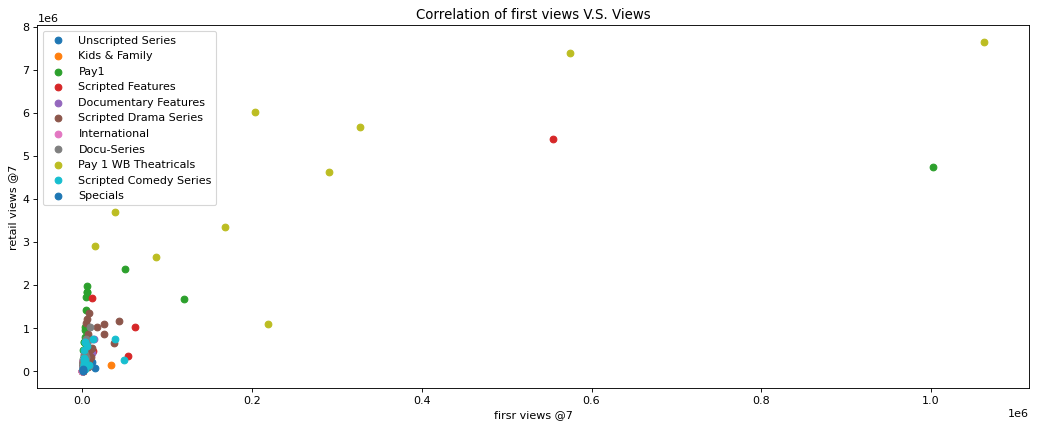

In [58]:
# SCatter of total views 
# plot_data = data[['retail_first_views_7', 'retail_viewed_count', 'category']]
figure(figsize=(16, 6), dpi=80)

for c in data.category.unique():
    plot_data = data[data['category'] == c]
    plt.scatter(plot_data['retail_first_views_7'], plot_data['retail_viewed_count'], label = c)
plt.title('Correlation of first views V.S. Views')
plt.xlabel('firsr views @7')
plt.ylabel('retail views @7')
plt.legend()
plt.show()

In [ ]:
# "Zack Snyder's Justice League", 'Mortal Kombat', 'Wonder Woman 1984', 'Godzilla vs. Kong'

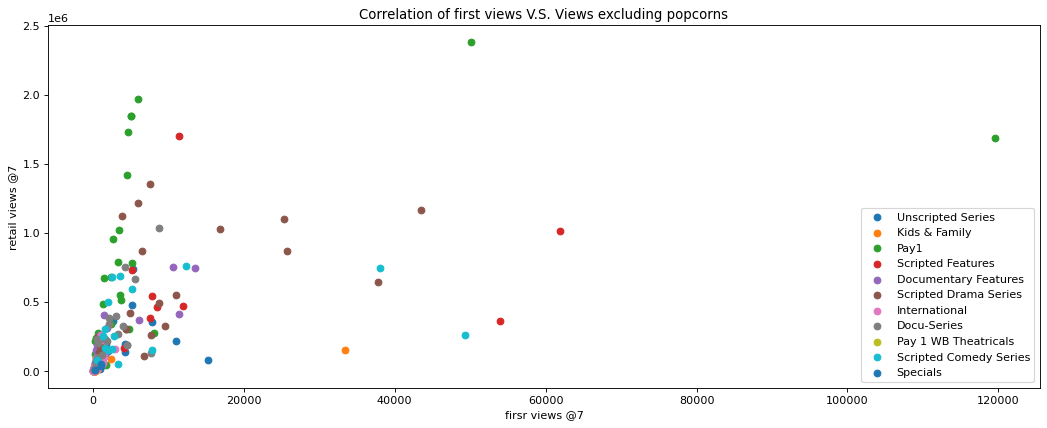

In [65]:
# SCatter of total views 
# plot_data = data[['retail_first_views_7', 'retail_viewed_count', 'category']]
figure(figsize=(16, 6), dpi=80)

for c in data.category.unique():
    plot_data = data[(data['category'] == c)
                    &~(data['title_name'].isin(["Zack Snyder's Justice League", 'Mortal Kombat', 'Wonder Woman 1984', 'Godzilla vs. Kong']))
                    &~(data['category'].isin(['Pay 1 WB Theatricals']))]
    plt.scatter(plot_data['retail_first_views_7'], plot_data['retail_viewed_count'], label = c)
plt.title('Correlation of first views V.S. Views excluding popcorns')
plt.xlabel('firsr views @7')
plt.ylabel('retail views @7')
plt.legend()
plt.show()

In [66]:
data=data.sort_values(by = ['tier'])

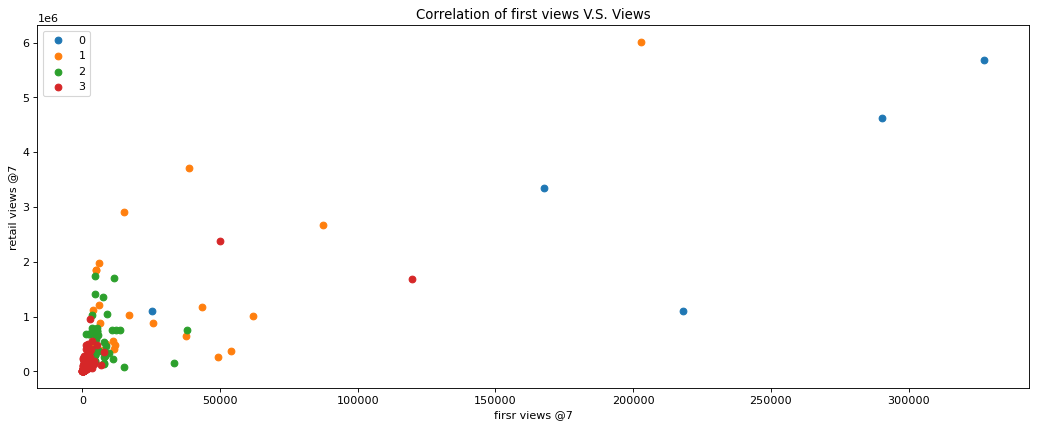

In [67]:
# SCatter of total views 
# plot_data = data[['retail_first_views_7', 'retail_viewed_count', 'category']]
figure(figsize=(16, 6), dpi=80)

for c in data.tier.unique():
    plot_data = data[(data['tier'] == c)
                    &~(data['title_name'].isin(["Zack Snyder's Justice League", 'Mortal Kombat', 'Wonder Woman 1984', 'Godzilla vs. Kong']))]
    plt.scatter(plot_data['retail_first_views_7'], plot_data['retail_viewed_count'], label = c)
plt.title('Correlation of first views V.S. Views')
plt.xlabel('firsr views @7')
plt.ylabel('retail views @7')
plt.legend()
plt.show()

In [137]:
data[data['retail_first_views_7']>150000].sort_values(by = ['retail_first_views_7'])

,title_name,match_id,retail_first_views_7,days_since_first_offered,retail_viewed_count,total_retail_sub_count,retail_viewed_count_percent,tier,category,season_number,effective_start_date,prequel_count,prequel_featured_count
27,The Little Things,GYA79hQZbUsI3gQEAAAB0,167507.0,28,3347097,8407793,0.398095,0,Pay 1 WB Theatricals,0,2021-01-29,0.0,0.0
147,Dune,GYUjdLgBiJp5otAEAAAAJ,202976.0,28,6014303,12919614,0.465517,1,Pay 1 WB Theatricals,0,2021-10-21,1.0,20.0
202,Tom & Jerry,GYEb9QwLgFF9_ZwEAAAA7,218131.0,28,1105964,9554805,0.115750,0,Pay 1 WB Theatricals,0,2021-02-26,0.0,0.0
79,The Conjuring: The Devil Made Me Do It,GYLEE7gB0zcLCwgEAAAHj,290232.0,28,4617129,12859293,0.359050,0,Pay 1 WB Theatricals,0,2021-06-04,2.0,20.0
73,Space Jam: A New Legacy,GYOSUnARCGWWmcAEAAAAC,327511.0,28,5681878,12803067,0.443790,0,Pay 1 WB Theatricals,0,2021-07-16,1.0,20.0
112,Zack Snyder's Justice League,GYDAnZgCFQ8IJpQEAAAAN,554391.0,28,5400655,11370473,0.474972,0,Scripted Features,0,2021-03-18,2.0,20.0
93,Mortal Kombat,GYGYKfQwaKLheqwEAAAEC,574506.0,28,7389661,12541255,0.589228,0,Pay 1 WB Theatricals,0,2021-04-23,1.0,20.0
99,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,1002389.0,28,4738180,7970401,0.594472,1,Pay1,0,2021-05-13,1.0,20.0
43,Godzilla vs. Kong,GYFEzmwNES16GkQEAAAAC,1062891.0,28,7651044,12260883,0.624021,0,Pay 1 WB Theatricals,0,2021-03-31,5.0,20.0


In [62]:
plot_data = final_data

In [63]:
category_onehot = pd.get_dummies(plot_data.category, prefix='category')
# category_onehot

In [64]:
plot_data=pd.concat([plot_data, category_onehot], axis = 1)

In [65]:
corr = plot_data.corr()[['retail_viewed_count_percent']]

In [66]:
mask=np.zeros_like(corr, dtype=np.bool)

In [67]:
corr.sort_values(by = ['retail_viewed_count_percent'])

,retail_viewed_count_percent
tier,-0.836957
category_International,-0.182591
category_Kids & Family,-0.144810
category_Documentary Features,-0.135082
category_Unscripted Series,-0.134612
season_number,-0.124119
category_Docu-Series,-0.071732
category_Specials,-0.071525
category_Scripted Comedy Series,-0.033239
category_Pay1,0.010865


<AxesSubplot:>

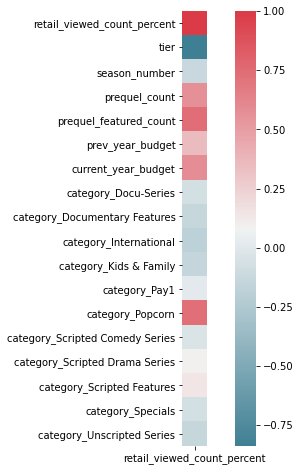

In [68]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

# Cross Validation

In [69]:
import xgboost  
from xgboost import XGBRegressor

In [55]:
data = final_data

In [56]:
train_data = data[['match_id', 'title_name', 'tier', 'category', 'season_number', 
                   'current_year_budget', 'prequel_count',
                   'prequel_featured_count', 'retail_viewed_count_percent', 'effective_start_date']]
category_onehot = pd.get_dummies(train_data.category, prefix='category')
train_data=pd.concat([train_data, category_onehot], axis = 1)
train_data.drop_duplicates(inplace = True)

In [57]:
FEATURE_COLS = [ 'tier', 'prequel_featured_count', 'category_Docu-Series', 'category_Documentary Features','season_number', 
                'current_year_budget', 'prequel_count',
       'category_International', 'category_Kids & Family', 'category_Pay1','category_Popcorn' , 'category_Scripted Comedy Series',
       'category_Scripted Drama Series', 'category_Scripted Features',
       'category_Specials', 'category_Unscripted Series']
TARGET_COL = ['retail_viewed_count_percent']

In [58]:
from sklearn.model_selection import KFold

In [59]:
n_title = len(train_data.match_id.unique())
kf = KFold(n_splits=n_title)

In [60]:
kf

KFold(n_splits=277, random_state=None, shuffle=False)

In [61]:
validation_set = pd.DataFrame()
feature_importances = pd.DataFrame()
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
for train_index, test_index in kf.split(train_data, groups=train_data['match_id'].values):
    train_df, test_df = train_data.iloc[train_index], train_data.iloc[test_index]
    # For pre-2019 titles, use all data as training set
    # For post-2019 titles, only use older titles as training set
    avail_date = test_df['effective_start_date'].values[0]
    train_df = train_df[(train_df['effective_start_date'] <= avail_date)]
    print ("Validation Title: " + test_df['title_name'].values[0])
    
    X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
    y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred = pd.DataFrame(pred)
    pred.columns = ['pred']
    test_df.reset_index(inplace = True, drop = True)
    test_df = pd.concat([test_df, pred], axis = 1)
    validation_set = pd.concat([validation_set, test_df], axis = 0)
      
    fi = model.feature_importances_
    fi_df = pd.DataFrame([fi])
    fi_df.columns = FEATURE_COLS
    fi_df['match_id'] = test_df['match_id'].values[0]
    fi_df['title_name'] = test_df['title_name'].values[0]
    feature_importances=pd.concat([feature_importances, fi_df], axis = 0)

Validation Title: Insecure


KeyboardInterrupt: 

In [ ]:
validation_set.to_csv('validation_set.csv')
feature_importances.to_csv('feature_importances.csv')

# Results

In [221]:
validation_set=pd.read_csv('validation_set.csv')
feature_importances = pd.read_csv('feature_importances.csv')

In [222]:
# Exclude some outliers
validation_set = validation_set[~(validation_set['match_id'].isin(['GYEb9QwLgFF9_ZwEAAAA7']))]

In [223]:
validation_set['mape'] = np.abs(validation_set['pred'] - validation_set['retail_viewed_count_percent'])/validation_set['retail_viewed_count_percent']
validation_set['mpe'] = (validation_set['pred'] - validation_set['retail_viewed_count_percent'])/validation_set['retail_viewed_count_percent']

In [240]:
validation_set[(validation_set['effective_start_date'] >= '2020-11-01')
              &(validation_set['effective_start_date'] < '2021-01-01')]

,Unnamed: 0,match_id,title_name,tier,category,season_number,current_year_budget,prequel_count,prequel_featured_count,retail_viewed_count_percent,effective_start_date,category_Docu-Series,category_Documentary Features,category_International,category_Kids & Family,category_Pay1,category_Popcorn,category_Scripted Comedy Series,category_Scripted Drama Series,category_Scripted Features,category_Specials,category_Unscripted Series,pred,mape,mpe,lower_index,upper_index,upper_bound,lower_bound,accuracy
13,0,GX3dOFgSA-4uZmAEAAAAi-1,Industry,3,Scripted Drama Series,1,100000.0,-1.0,-1.0,0.043120,2020-11-10,0,0,0,0,0,0,0,1,0,0,0,0.036117,0.162410,-0.162410,-0.149430,0.385770,0.042462,0.026063,0.0
14,0,GX3hmdAVQOYuZmAEAAAEJ-1,Murder on Middle Beach,2,Docu-Series,1,NaN,-1.0,-1.0,0.056941,2020-11-16,1,0,0,0,0,0,0,0,0,0,0,0.055411,0.026864,-0.026864,-0.443018,0.649963,0.099485,0.033583,1.0
17,0,GX4cp4Aifr2NViQEAAAJS,Wendy,3,Pay1,0,NaN,0.0,0.0,0.016337,2020-12-20,0,0,0,0,1,0,0,0,0,0,0,0.028492,0.744009,0.744009,-0.379052,0.194060,0.045884,0.023861,0.0
19,0,GX5MHsQzwwIuLwgEAAACp-1,The Flight Attendant,0,Scripted Drama Series,1,9193000.0,-1.0,-1.0,0.210001,2020-11-26,0,0,0,0,0,0,0,1,0,0,0,0.169610,0.192336,-0.192336,-0.149430,0.385770,0.199408,0.122394,0.0
20,0,GX5lfBgOJ7RKRwgEAAAMG,The Bee Gees: How Can You Mend A Broken Heart,2,Documentary Features,0,NaN,0.0,0.0,0.048931,2020-12-13,0,1,0,0,0,0,0,0,0,0,0,0.048065,0.017697,-0.017697,-0.779621,0.096659,0.218102,0.043829,1.0
22,0,GX6AKHwKaG8PDUAEAAAAC,Superintelligence,2,Scripted Features,0,NaN,0.0,0.0,0.077639,2020-11-26,0,0,0,0,0,0,0,0,1,0,0,0.055004,0.291546,-0.291546,-0.621973,0.622865,0.145502,0.033893,1.0
23,0,GX72QuwdZ0yGqwgEAAAY4-1,Heaven's Gate: The Cult of Cults,2,Docu-Series,1,NaN,-1.0,-1.0,0.057787,2020-12-03,1,0,0,0,0,0,0,0,0,0,0,0.055900,0.032655,-0.032655,-0.443018,0.649963,0.100362,0.033880,1.0
24,0,GX7QU5AGnhiLDwwEAAAAj,The Fresh Prince of Bel-Air Reunion,1,Specials,0,NaN,1.0,20.0,0.133703,2020-11-19,0,0,0,0,0,0,0,0,0,1,0,0.153745,0.149896,0.149896,-0.487685,0.160480,0.300098,0.132484,1.0
25,0,GX7UW-gGlNpGpwgEAAAQk,Alabama Snake,3,Documentary Features,0,NaN,0.0,0.0,0.018410,2020-12-10,0,1,0,0,0,0,0,0,0,0,0,0.005476,0.702553,-0.702553,-0.779621,0.096659,0.024848,0.004993,1.0
26,0,GX7WPJgqYpLZJwwEAAABu,Euphoria Special Episode Part 1: Rue,2,Specials,0,NaN,0.0,0.0,0.079979,2020-12-04,0,0,0,0,0,0,0,0,0,1,0,0.041963,0.475320,-0.475320,-0.487685,0.160480,0.081909,0.036160,1.0


In [224]:
validation_set.groupby(['category']).mape.mean()

category
Docu-Series               1.112872
Documentary Features      1.015664
International             8.580576
Kids & Family             6.648570
Pay1                      0.417464
Popcorn                   0.268391
Scripted Comedy Series    0.728217
Scripted Drama Series     0.505730
Scripted Features         0.444665
Specials                  1.240786
Unscripted Series         1.225073
Name: mape, dtype: float64

In [225]:
validation_set.groupby(['tier']).mape.mean()

tier
0    0.295790
1    0.376480
2    1.028806
3    3.234757
Name: mape, dtype: float64

In [227]:
# validation_set.groupby(['program_type', 'content_category']).mape.mean()

In [228]:
validation_set['effective_start_date']=pd.to_datetime(validation_set['effective_start_date'])

In [229]:
validation_set=validation_set[(validation_set['retail_viewed_count_percent']>0.01)
                             &~(validation_set['category'].isin(['Kids & Family', 'International']))]

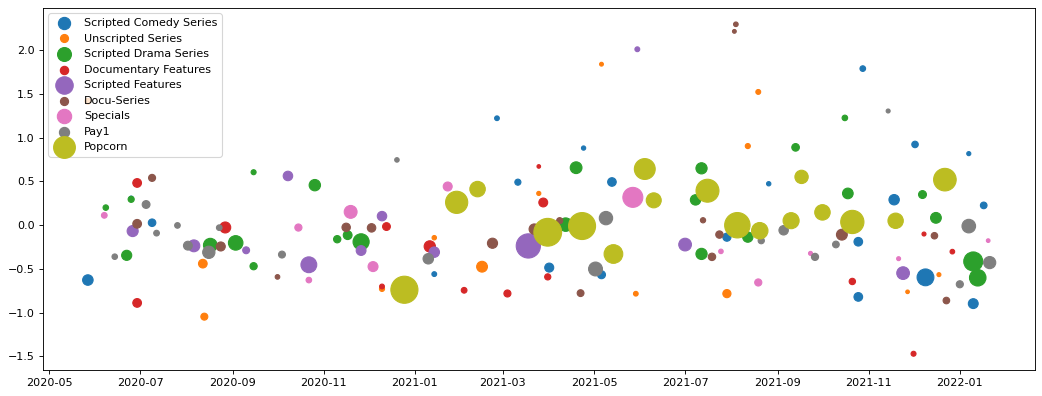

In [230]:
figure(figsize=(16, 6), dpi=80)
for c in validation_set.category.unique():
    plot_data = validation_set[validation_set['category'] == c]
    plt.scatter(plot_data['effective_start_date'], plot_data['mpe'], label = c, s = plot_data['retail_viewed_count_percent']*1000)
# plt.title('Correlation of first views V.S. Views')
# plt.xlabel('firsr views @7')
# plt.ylabel('retail views @7')
plt.legend()
plt.show()

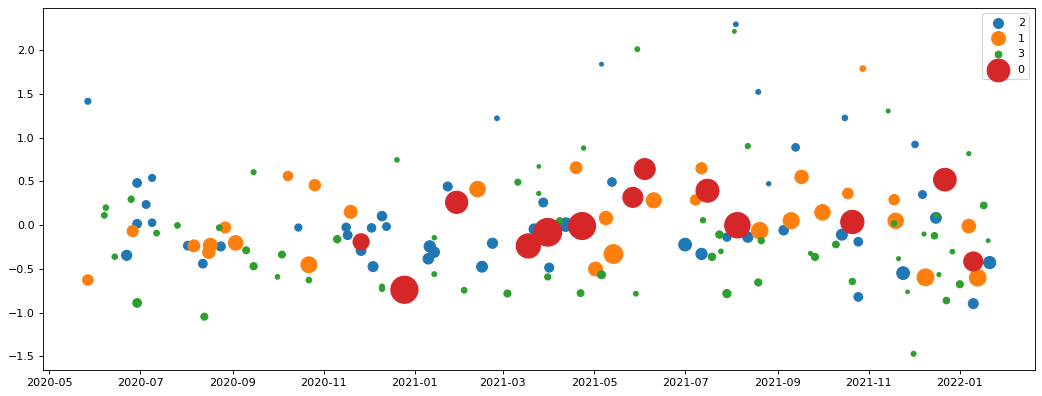

In [231]:
figure(figsize=(16, 6), dpi=80)
for c in validation_set.tier.unique():
    plot_data = validation_set[validation_set['tier'] == c]
    plt.scatter(plot_data['effective_start_date'], plot_data['mpe'], label = c, s = plot_data['retail_viewed_count_percent']*1000)
# plt.title('Correlation of first views V.S. Views')
# plt.xlabel('firsr views @7')
# plt.ylabel('retail views @7')
plt.legend()
plt.show()

In [232]:
def ci_calculation(data, ci_level = 0.99, field = 'mpe'):
    data = data[data[field].notnull()][field]
    lower, upper = st.t.interval(alpha=ci_level, 
                         df=len(data)-1, 
                         loc=np.mean(data), 
                         scale=st.sem(data)) 
    return lower, upper

In [233]:
ci_df = validation_set.groupby(['category']).apply(ci_calculation)
ci_df = pd.DataFrame(ci_df).reset_index()
ci_df.columns = ['category', 'multiplier']
ci_df['lower_index'], ci_df['upper_index'] = zip(*ci_df['multiplier'])
ci_df['lower_index'] = ci_df['lower_index'].fillna(1)
ci_df['upper_index'] = ci_df['upper_index'].fillna(1)
ci_df.drop(['multiplier'], axis = 1, inplace = True)

In [234]:
validation_set = pd.merge(validation_set, ci_df, on = ['category'],
                         how = 'left')

In [235]:
validation_set['upper_bound'] = validation_set['pred']/(1+validation_set['lower_index'])
validation_set['lower_bound'] = validation_set['pred']/(1+validation_set['upper_index'])

In [236]:
# validation_set.drop(['accuracy'], axis = 1, inplace = True)
validation_set.loc[(validation_set['retail_viewed_count_percent']>=validation_set['lower_bound'])
                  &(validation_set['retail_viewed_count_percent']<=validation_set['upper_bound']), 'accuracy'] = 1
validation_set['accuracy'] = validation_set['accuracy'].fillna(0)

In [237]:
validation_set.accuracy.mean()

0.5769230769230769

In [238]:
len(validation_set[validation_set['accuracy'] == 1].match_id.unique())/len(validation_set.match_id.unique())

0.5882352941176471

# Predictions

In [84]:
prediction_titles = ["Hacks"]

In [85]:
fv_pre[fv_pre['title_name'].str.contains('Hacks')]

,Unnamed: 0,prequel_featured_count,category,prequel_count,season_number,effective_start_date,tier,tier_adj,title_name,content_category,first_views_log_pred,first_views_pred,pred_date,decay_category
305,305,-1.0,Scripted Comedy Series,-1.0,1,2021-05-13,2,2,Hacks,series,9.924792,20430.666,2022-03-22,Scripted Comedy Series
306,306,-1.0,Scripted Comedy Series,-1.0,2,2022-05-19,2,2,Hacks,series,9.924792,20430.666,2022-03-22,Scripted Comedy Series
307,307,-1.0,Scripted Comedy Series,-1.0,3,2023-05-04,2,2,Hacks,series,9.924792,20430.666,2022-03-22,Scripted Comedy Series


In [86]:
fv_pre['category'] = fv_pre['category'].str.replace('Pay 1 WB Theatricals', 'Popcorn')

In [88]:
pred_df = fv_pre[fv_pre['title_name'].str.upper().isin(x.upper() for x in prediction_titles)]

In [90]:
pred_df=pred_df[['title_name', 'tier', 'category', 'season_number', 'prequel_featured_count', 'effective_start_date']]
category_onehot = pd.get_dummies(pred_df.category, prefix='category')
pred_df=pd.concat([pred_df, category_onehot], axis = 1)
pred_df.drop_duplicates(inplace = True)

In [91]:
for c in train_data.columns:
    if c not in pred_df.columns and c not in ['match_id', 'retail_viewed_count_percent']:
        print (c)
        pred_df[c] = 0

current_year_budget
prequel_count
category_Docu-Series
category_Documentary Features
category_International
category_Kids & Family
category_Pay1
category_Popcorn
category_Scripted Drama Series
category_Scripted Features
category_Specials
category_Unscripted Series


In [92]:
# train_data['category_Pay 1 WB Theatricals'] = 0
# pred_df['category_Pay 1 WB Theatricals'] = 0

In [93]:
prediction_set = pd.DataFrame()
feature_importances = pd.DataFrame()
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

train_df, test_df = train_data, pred_df

X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
y_train = train_df[TARGET_COL]

model.fit(X_train, y_train)
pred = model.predict(X_test)
pred = pd.DataFrame(pred)
pred.columns = ['pred']
test_df.reset_index(inplace = True, drop = True)
test_df = pd.concat([test_df, pred], axis = 1)
prediction_set = pd.concat([prediction_set, test_df], axis = 0)

fi = model.feature_importances_
fi_df = pd.DataFrame([fi])
fi_df.columns = FEATURE_COLS
fi_df['title_name'] = test_df['title_name'].values[0]
feature_importances=pd.concat([feature_importances, fi_df], axis = 0)

In [94]:
prediction_set[['title_name', 'category', 'season_number', 'effective_start_date', 'pred']].sort_values(by = ['effective_start_date'])

,title_name,category,season_number,effective_start_date,pred
0,Hacks,Scripted Comedy Series,1,2021-05-13,0.072582
1,Hacks,Scripted Comedy Series,2,2022-05-19,0.039707
2,Hacks,Scripted Comedy Series,3,2023-05-04,0.041917


In [114]:
pred_df

,title_name,tier,category,season_number,prequel_featured_count,effective_start_date,category_Popcorn,category_Scripted Comedy Series,category_Scripted Drama Series,category_Docu-Series,category_Documentary Features,category_International,category_Kids & Family,category_Pay1,category_Scripted Features,category_Specials,category_Unscripted Series
0,Barry,2,Scripted Comedy Series,3,-1.00000,2022-04-24,0,1,0,0,0,0,0,0,0,0,0
1,Barry,2,Scripted Comedy Series,4,-1.00000,2023-04-02,0,1,0,0,0,0,0,0,0,0,0
2,Barry,2,Scripted Comedy Series,5,-1.00000,2024-04-21,0,1,0,0,0,0,0,0,0,0,0
3,The Batman,1,Popcorn,0,16.12766,2022-04-18,1,0,0,0,0,0,0,0,0,0,0
4,The Flight Attendant,0,Scripted Drama Series,2,-1.00000,2022-04-21,0,0,1,0,0,0,0,0,0,0,0
5,The Flight Attendant,0,Scripted Drama Series,3,-1.00000,2023-11-23,0,0,1,0,0,0,0,0,0,0,0


In [48]:
for i in prediction_titles:
    if i not in prediction_set.title_name.unique():
        print  (i) 

Harry Potter 20th Anniversary: Return to Hogwarts
Winning Time
Harley Quinn S3
House of the Dragon
Lizzo: Good As Hell
The White House Plumbers
DC League of Super Pets
The Big Brunch


In [91]:
feature_importances

,tier,prequel_featured_count,category_Docu-Series,category_Documentary Features,season_number,category_International,category_Kids & Family,category_Pay1,category_Popcorn,category_Scripted Comedy Series,category_Scripted Drama Series,category_Scripted Features,category_Specials,category_Unscripted Series,title_name
0,0.254724,0.13892,0.021407,0.013716,0.01744,0.008173,0.024667,0.016183,0.358347,0.044959,0.040127,0.026835,0.024152,0.01035,The Batman


# Metric Comparison

In [24]:
retail_active = run_query('''
select * from max_dev.workspace.title_active_retail_funnel_metrics

''')

In [27]:
retail_view[retail_view['title_name'].str.contains('Harry Potter 20th Anniversary: Return to Hogwarts')]

,title_name,match_id,season_number,content_category,single_episode_ind,platform_name,earliest_offered_timestamp,last_offered_timestamp,earliest_public_timestamp,days_since_first_offered,total_retail_sub_count,last_update_timestamp,retail_played_count,retail_viewed_count,retail_completion_count,retail_played_count_percent,retail_viewed_count_percent
35298,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,NaN,special,1,hboMax,2022-01-01 08:01:00,2022-01-01 08:01:00,2022-01-01 08:01:00,90,18061644.0,2022-04-02,4847698.0,4573471.0,3010259.0,0.268397,0.253215
77373,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,NaN,special,1,hboMax,2022-01-01 08:01:00,2022-01-01 08:01:00,2022-01-01 08:01:00,28,15977921.0,2022-03-30,4337121.0,4093935.0,2736753.0,0.271445,0.256225
85049,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,NaN,special,1,hboMax,2022-01-01 08:01:00,2022-01-01 08:01:00,2022-01-01 08:01:00,24,15780672.0,2022-03-30,4267194.0,4028320.0,2696725.0,0.270406,0.255269
115883,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,NaN,special,1,hboMax,2022-01-01 08:01:00,2022-01-01 08:01:00,2022-01-01 08:01:00,6,14393512.0,2022-03-30,3359730.0,3166952.0,2126029.0,0.233420,0.220026
122459,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,NaN,special,1,hboMax,2022-01-01 08:01:00,2022-01-01 08:01:00,2022-01-01 08:01:00,3,14263832.0,2022-03-30,2907366.0,2742551.0,1828451.0,0.203828,0.192273
128357,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,NaN,special,1,hboMax,2022-01-01 08:01:00,2022-01-01 08:01:00,2022-01-01 08:01:00,5,14349599.0,2022-03-30,3249288.0,3059583.0,2050854.0,0.226438,0.213217
132657,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,NaN,special,1,hboMax,2022-01-01 08:01:00,2022-01-01 08:01:00,2022-01-01 08:01:00,4,14309254.0,2022-03-30,3100115.0,2922570.0,1956400.0,0.216651,0.204243
139349,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,NaN,special,1,hboMax,2022-01-01 08:01:00,2022-01-01 08:01:00,2022-01-01 08:01:00,2,14208885.0,2022-03-30,2627677.0,2475181.0,1633642.0,0.184932,0.174200
140929,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,NaN,special,1,hboMax,2022-01-01 08:01:00,2022-01-01 08:01:00,2022-01-01 08:01:00,1,14109134.0,2022-03-30,2008329.0,1873192.0,1193019.0,0.142342,0.132764
143161,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,NaN,special,1,hboMax,2022-01-01 08:01:00,2022-01-01 08:01:00,2022-01-01 08:01:00,20,15503235.0,2022-03-30,4164149.0,3930865.0,2635343.0,0.268599,0.253551


In [25]:
retail_active.head()

,title_name,match_id,season_number_adj,content_category,single_episode_ind,platform_name,earliest_offered_timestamp,last_offered_timestamp,earliest_public_timestamp,days_since_first_offered,total_retail_active_sub_count,last_update_timestamp,retail_play_count,retail_view_count,retail_completion_count,retail_active_percent_play,retail_active_percent_view


# 28th day V.S. 140th day

In [69]:
view_data = run_query('''
select a.match_id, a.RETAIL_VIEWED_COUNT_PERCENT as view_28, view_140
from max_prod.workspace.title_retail_funnel_metrics  a 
join (
select MATCH_ID, RETAIL_VIEWED_COUNT_PERCENT as view_140 from max_prod.workspace.title_retail_funnel_metrics 
  where DAYS_SINCE_FIRST_OFFERED =140
) b
ON a.MATCH_ID = b.MATCH_ID
WHERE a.DAYS_SINCE_FIRST_OFFERED =28
''')

In [82]:
view_data.view_28.max()

0.623174

In [71]:
view_data = pd.merge(view_data, metadata_feature, on = ['match_id'])

In [83]:
view_data=view_data[view_data['view_28']> 0.01]

In [97]:
plot_data['view_28'].values[0]

0.087811

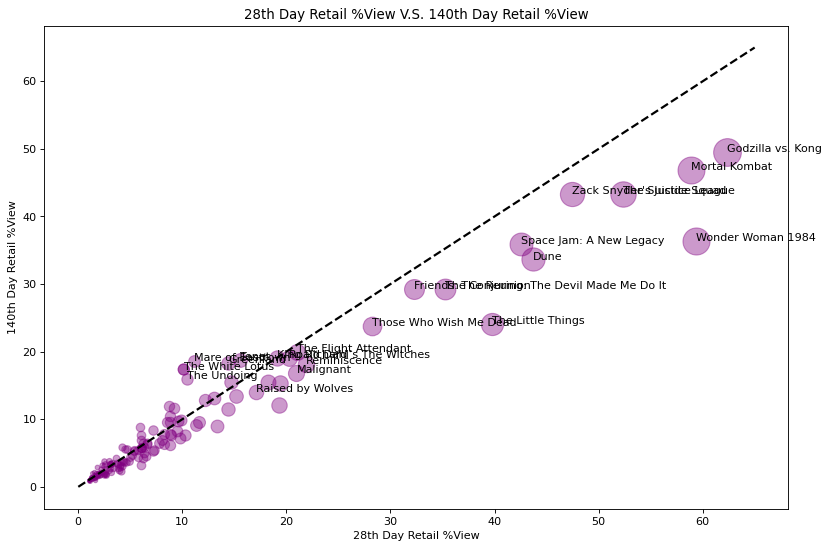

In [112]:
figure(figsize=(12, 8), dpi=80)
for m in view_data.match_id.unique():
    plot_data = view_data[view_data['match_id'] == m]
    plt.scatter(plot_data['view_28']*100, 
                plot_data['view_140']*100, 
                s = plot_data['view_28']*1000, 
                c = 'purple',
                alpha=0.4)
    if (plot_data['view_140'].values[0]> 0.16) or (plot_data['title_name'].values[0] == 'Raised by Wolves'):
        plt.text(plot_data['view_28'].values[0]*100,
                 plot_data['view_140'].values[0]*100, 
                 plot_data['title_name'].values[0])
plt.plot([0,65], [0, 65], color='k', linestyle='--', linewidth=2)
plt.title('28th Day Retail %View V.S. 140th Day Retail %View')
plt.xlabel('28th Day Retail %View')
plt.ylabel('140th Day Retail %View')
plt.show()

In [258]:
view_data = run_query('''
select title, b.match_id, b.PCT_ACTIVES as pct_actives_28, FVPCT as pct_fv_56
from max_dev.workspace.cds_historical_firstview_pct a 
join max_PROD.workspace.pct_actives_metric_values_pipeline b 
on a.MATCH_ID  = b.MATCH_ID
where 1=1
and a.WINDOW = 56
and b.DAYS_ON_HBO_MAX = 28
''')

In [82]:
view_data.view_28.max()

0.623174

In [71]:
view_data = pd.merge(view_data, metadata_feature, on = ['match_id'])

In [83]:
view_data=view_data[view_data['view_28']> 0.01]

In [97]:
plot_data['view_28'].values[0]

0.087811

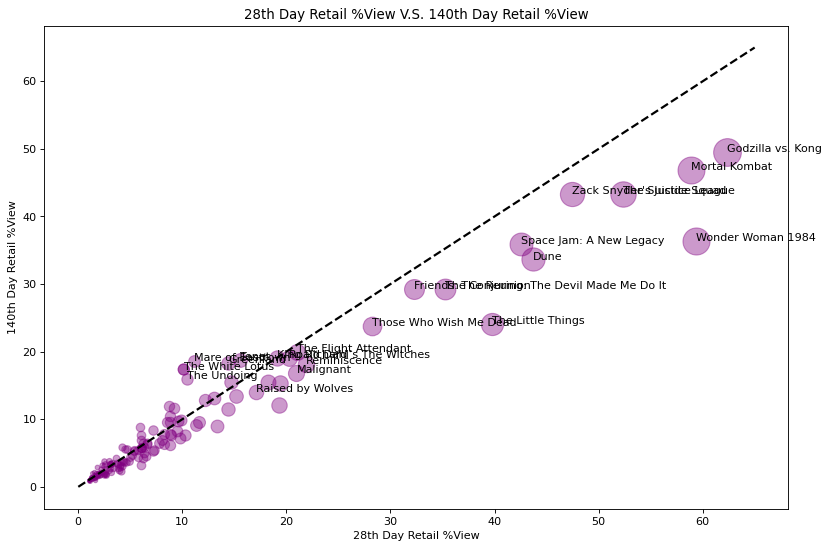

In [112]:
figure(figsize=(12, 8), dpi=80)
for m in view_data.match_id.unique():
    plot_data = view_data[view_data['match_id'] == m]
    plt.scatter(plot_data['view_28']*100, 
                plot_data['view_140']*100, 
                s = plot_data['view_28']*1000, 
                c = 'purple',
                alpha=0.4)
    if (plot_data['view_140'].values[0]> 0.16) or (plot_data['title_name'].values[0] == 'Raised by Wolves'):
        plt.text(plot_data['view_28'].values[0]*100,
                 plot_data['view_140'].values[0]*100, 
                 plot_data['title_name'].values[0])
plt.plot([0,65], [0, 65], color='k', linestyle='--', linewidth=2)
plt.title('28th Day Retail %View V.S. 140th Day Retail %View')
plt.xlabel('28th Day Retail %View')
plt.ylabel('140th Day Retail %View')
plt.show()